# Práctica 3: Redes neuronales convolucionales para clasificación de imágenes

En esta práctica, vamos a utilizar modelos profundos para clasificar dígitos manuscritos, de forma similar al práctico 1. En este caso, utilizaremos el dataset MNIST donde los dígitos poseen un tamaño de 28x28 (en lugar de 8x8 como en dicho práctico). 

Para eso, comenzamos por cargar y visualizar el dataset:

In [9]:
# Activate ext autoreload 
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os 
import torchvision
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from utils.trainer_graphs import trainer,showTestResults
# entorno para usar la gpu 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print('Is GPU available?', torch.cuda.is_available())
print('Model of the GPU:', torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Is GPU available? True
Model of the GPU: NVIDIA GeForce RTX 2060


/usr/lib/python3/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


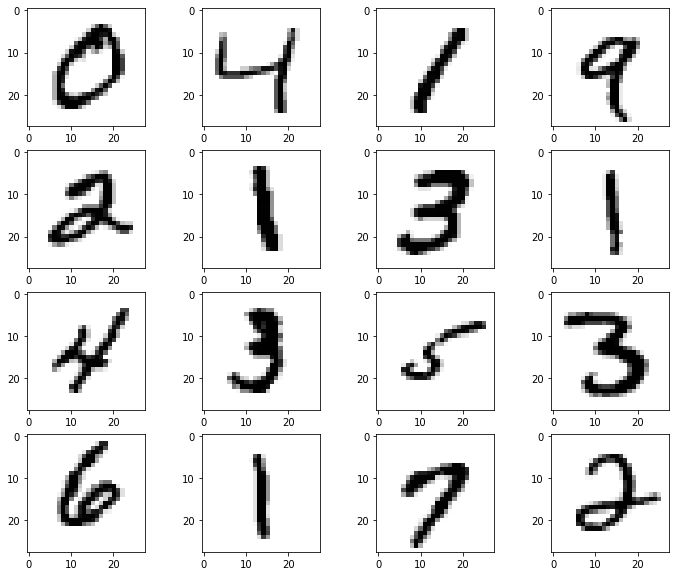

In [2]:
plt.rcParams['figure.figsize'] = [12, 10]
mnist_train = datasets.MNIST(root='./Practica3/data', 
                             train=True, 
                             download=True, 
                             transform=torchvision.transforms.ToTensor())
mnist_test = datasets.MNIST(root='./Practica3/data', 
                            train=False, 
                            download=True, 
                            transform=torchvision.transforms.ToTensor())
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(mnist_train.train_data[i,:,:], cmap=plt.get_cmap('gray_r'))    

# Perceptrón multicapa

Primero, vamos a adaptar el perceptrón mutlicapa implementado en la práctica anterior, para que pueda clasificar imágenes de 28 x 28 en 10 categorías diferentes. Para ello, deberemos realizar algunos cambios:

* Antes de procesar la imagen, deberemos reformatearla para que pase de ser una imagen de 28 x 28, a un vector de 784 componetes. Para ello, utilziaremos el método `view` de los tensores de Pytorch.

* Utilizaremos un perceptrón con 15 neuronas en las capas intermedias.

* La última capa deberá tener 10 neuronas (en lugar de 1 sola como tenia el perceptrón multicapa que utilizamos para hacer regresión).

* Deberemos cambiar la función de pérdida. En este caso, utilizaremos Entropía Cruzada (`torch.nn.CrossEntropyLoss`)

In [3]:
class NetMLP(torch.nn.Module):
    def __init__(self, input_features, size_hidden, n_output):
        super(NetMLP, self).__init__()
        self.input_features = input_features
        self.hidden1 = nn.Linear(input_features,size_hidden)
        self.hidden2 = nn.Linear(size_hidden,size_hidden)
        self.out = nn.Linear(size_hidden,n_output)

    def forward(self, x):
        x = x.view(-1, self.input_features)
        x = F.relu(self.hidden1(x))         # linear output
        x = F.relu(self.hidden2(x))
        output = F.softmax(self.out(x),dim=1) 
        return output

Current device is cuda:0
1.4621542692184448


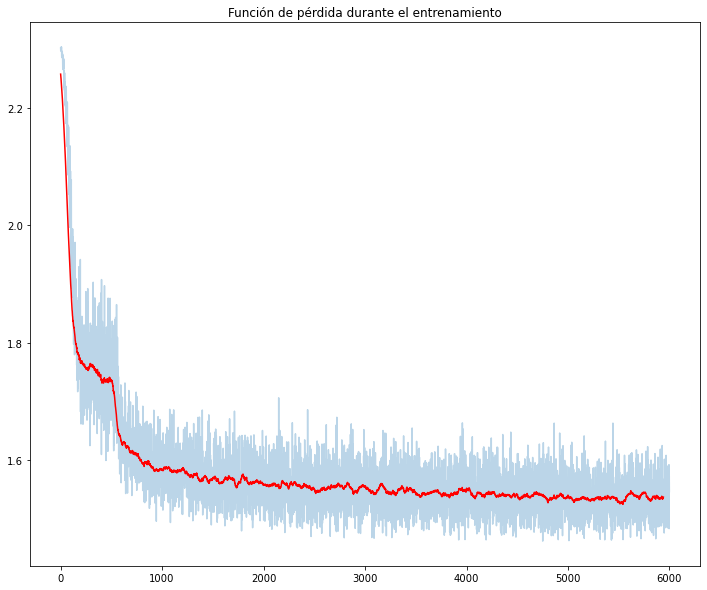

In [4]:
input_features = 28*28
hidden_neurons = 15
num_outputs = 10
args = {'num_epochs':5, 'learning_rate':1e-3,'batch_size':50,
           'dataset':mnist_train #dataset para el entrenamiento
       }
#X,y = [mnist_train,mnist_test],[y_train,y_test]
net = NetMLP(input_features, hidden_neurons, num_outputs)
criterion = nn.CrossEntropyLoss()
trainer(net,criterion,args)

### Guardamos el modelo para poder reutilizarlo

In [5]:
torch.save(net.state_dict(), "./Practica3/mlp20.pth") #

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [7]:
# Cargo el modelo guardado (si el modelo se encuentra en memoria, este paso no es necesario)
input_features = 28*28
hidden_neurons = 15
num_outputs = 10
net = NetMLP(input_features,hidden_neurons,num_outputs)
net.load_state_dict(torch.load("./Practica3/mlp20.pth"))
net.to(device)

NetMLP(
  (hidden1): Linear(in_features=784, out_features=15, bias=True)
  (hidden2): Linear(in_features=15, out_features=15, bias=True)
  (out): Linear(in_features=15, out_features=10, bias=True)
)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       980
           1       0.96      0.97      0.96      1135
           2       0.90      0.85      0.87      1032
           3       0.87      0.88      0.87      1010
           4       0.89      0.90      0.89       982
           5       0.79      0.66      0.72       892
           6       0.84      0.88      0.86       958
           7       0.89      0.90      0.90      1028
           8       0.81      0.86      0.84       974
           9       0.87      0.86      0.87      1009

    accuracy                           0.88     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.88      0.88     10000



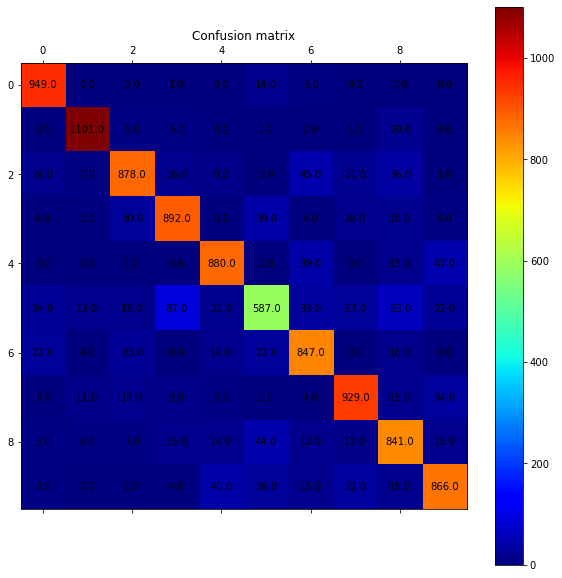

In [12]:
showTestResults(net,mnist_test)

# Red Neuronal Convolucional

También definiremos un modelo NetCNN que implemente una red neuronal convolucional, el cual seguirá la siguiente estructura:
* Capa convolucional (`nn.Conv2D`) (6 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa convolucional (`nn.Conv2D`) (16 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa totalmente conectada (`nn.Linear`) (120 neuronas) + ReLU
* Capa totalmente conectada (`nn.Linear`) (84 neuronas) + ReLU
* Capa de salida (`nn.Linear`) (10 neuronas)

Notar que utilizaremos la función `CrossEntropyLoss` para entrenar el modelo. Recordar que dados:
* F: tamaño del filtro
* W: Tamaño del feature map de entrada
* P: Padding
* S: Stride

El tamaño de la salida es $O = \frac{(W - F + 2P)}{S} + 1$


In [13]:
class NetCNN(nn.Module):
    def __init__(self,kernel_s,strides,n):
        ks1, ks2 = kernel_s 
        s1,s2 = strides
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                             out_channels=6,
                             kernel_size=ks1,stride=s1)
        self.conv2 = nn.Conv2d(in_channels=6,
                             out_channels=16,
                             kernel_size=ks2,stride=s2)
        self.fc1=nn.Linear(16*n*n,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        # Al pasar de capa convolucional a capa totalmente conectada, tenemos
        # que reformatear la salida para que se transforme en un vector unidimensional
        x = x.view(-1,16*n*n)
        #x = x.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        return x

Current device is cuda:0
1.4611506462097168


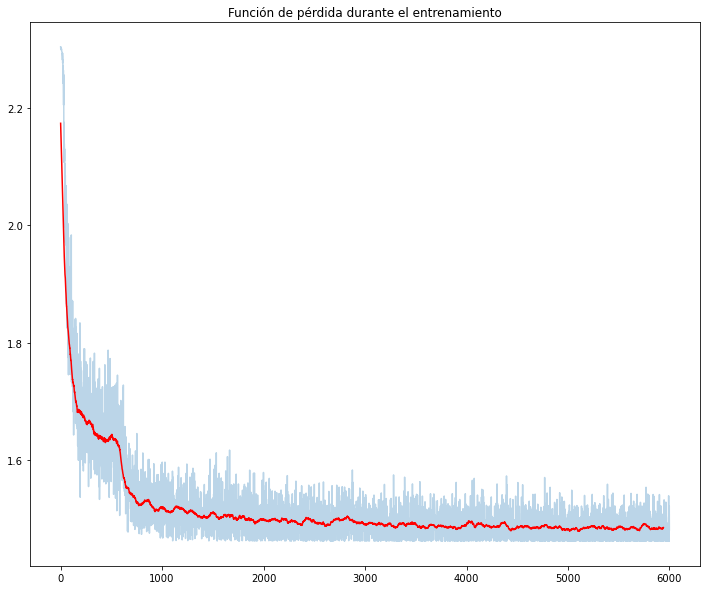

In [15]:
args = {'num_epochs':5, 'learning_rate':1e-3,'batch_size':50,
           'dataset':mnist_train #dataset para el entrenamiento
       }
kernels = [5,3]
strides = [1,1]
n = 5
net2 = NetCNN(kernels,strides,n)
criterion = nn.CrossEntropyLoss()
trainer(net2,criterion,args)

### Guardo el modelo

In [ ]:
torch.save(net.state_dict(), "./Practica3/cnn21.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [18]:
net = NetCNN(kernels,strides,n)
net.load_state_dict(torch.load("./Practica3/cnn21.pth"))
net.to(device)

NetCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.97      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.97      0.96      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.96      0.97      0.96       892
           6       0.97      0.97      0.97       958
           7       0.97      0.94      0.95      1028
           8       0.92      0.96      0.94       974
           9       0.96      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



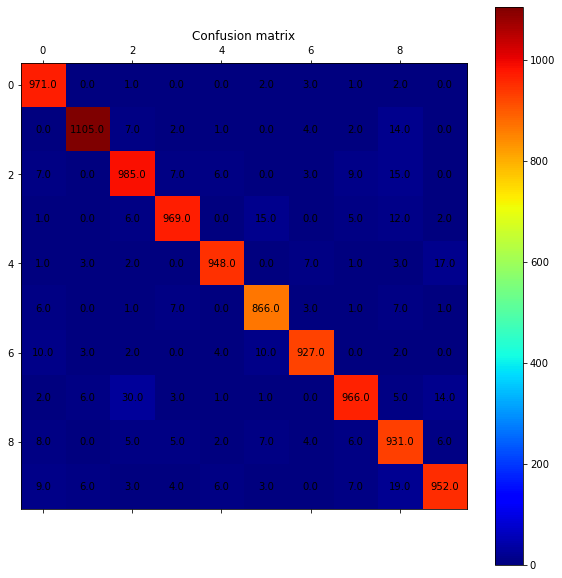

In [20]:
showTestResults(net,mnist_test)

# Entregable

1. Implementar el perceptrón multicapa y la red neuronal convolucional solicitadas.

2. Para el caso de la red neuronal convolucional, realizar el cálculo del tamaño de la entrada y salida en cada capa convolucional en función de los parámetros de cada capa (tamaño del kernel, padding, stride, etc) para garantizar que los tensores que fluyen por la red sean del tamaño adecuado. Indicar el tamaño de los feature maps a medida que fluyen por la red.

3. Comparar la accuracy obtenida por el perceptrón muticapa y la red neuronal convolucional. 

2.  
Calculo para la red conv:
(Para la red que me dio "mejores" resultados)

* input: matriz de 28x28.
* primer capa: kernel de dimesion 5x5 con 6 niveles de profunidad, stride=1 y funcion de activacion ReLU -> 6 matrices de 24x24.
* aplicamos un maxPool de 2x2 (a cada una),stride=2 -> 6 matrices de 12x12.
* se aplica: kernel de 3x3x6 con 16 niveles de profundidad con stride 1, nuevamente con ReLU resultando en 16 matrices de 10x10. 
* aplicamos: maxPooling de 2x2, stride=2 -> 16 matrices de 5x5. 
* aplicamos: view -> 16*5*5 nodos en nuestra capa densa.
* capas ocultas: tamaños 120, 84 y 10(ambas densas), ReLU como funcion de activacion y para la salida, aplicamos softmax.


3.

accuracy(`MLP`) = 0.88 

accuracy(`CNN`) = 0.96